# Updates

* 

---

# Setup

##### Imports

In [386]:
import os

import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

##### Set Root Dir as CWD

In [2]:
# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
train_all = pd.read_pickle(path + "train.xz")

CPU times: total: 28.9 s
Wall time: 29.2 s


In [5]:
%%time
# Load test set (10% of total data) as test
test_all = pd.read_pickle(path + "test.xz")

CPU times: total: 3.55 s
Wall time: 3.62 s


In [6]:
num_samples = (200_000, 10_000)

train = train_all.iloc[:num_samples[0]]
test = test_all.iloc[:num_samples[1]]

In [7]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
5605237,"Great experience, terrific dinner. Tour of the...",5
811804,We have gone three times and I'm waiting for a...,1
6197443,1st review:\nMeatball grinder was incredibly b...,1
6379002,This place is fantastic! The best old tyme ice...,5


##### Save Target

In [8]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

##### Create Pipeline

In [9]:
# Requires download
#   $ python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser"])

In [10]:
print(nlp.analyze_pipes(pretty=True))


============================= Pipeline Overview =============================

#   Component         Assigns          Requires   Scores          Retokenizes
-   ---------------   --------------   --------   -------------   -----------
0   tok2vec           doc.tensor                                  False      
                                                                             
1   tagger            token.tag                   tag_acc         False      
                                                                             
2   attribute_ruler                                               False      
                                                                             
3   lemmatizer        token.lemma                 lemma_acc       False      
                                                                             
4   ner               doc.ents                    ents_f          False      
                      token.ent_iob               ents_p      

In [11]:
i = 9

# Get a single sentence as an example
example = [test["text"].iloc[i]]

# Create a spacy doc with the example
example_doc = list(nlp.pipe(example))[0]
print(example_doc)

Great prices and a fabulous team to help with all your fabric needs! I've especially enjoyed working with the owner Kathy! Beautiful cushions, valances, drapes, and pillows!


In [12]:
# Tokenization example
for token in example_doc:
    print("[" + token.text + "]", end="")

[Great][prices][and][a][fabulous][team][to][help][with][all][your][fabric][needs][!][I]['ve][especially][enjoyed][working][with][the][owner][Kathy][!][Beautiful][cushions][,][valances][,][drapes][,][and][pillows][!]

In [13]:
for token in example_doc:
    # Print text, simple POS, detailed POS, shape, whether alphabetical, whether stopword
    print("[", token.text, token.lemma_, token.pos_, token.tag_,
          token.shape_, token.is_alpha, token.is_stop, "]", end="")

[ Great great ADJ JJ Xxxxx True False ][ prices price NOUN NNS xxxx True False ][ and and CCONJ CC xxx True True ][ a a DET DT x True True ][ fabulous fabulous ADJ JJ xxxx True False ][ team team NOUN NN xxxx True False ][ to to PART TO xx True True ][ help help VERB VB xxxx True False ][ with with ADP IN xxxx True True ][ all all DET DT xxx True True ][ your your PRON PRP$ xxxx True True ][ fabric fabric NOUN NN xxxx True False ][ needs need NOUN NNS xxxx True False ][ ! ! PUNCT . ! False False ][ I I PRON PRP X True True ][ 've 've AUX VBP 'xx False True ][ especially especially ADV RB xxxx True False ][ enjoyed enjoy VERB VBN xxxx True False ][ working work VERB VBG xxxx True False ][ with with ADP IN xxxx True True ][ the the DET DT xxx True True ][ owner owner NOUN NN xxxx True False ][ Kathy Kathy PROPN NNP Xxxxx True False ][ ! ! PUNCT . ! False False ][ Beautiful beautiful ADJ JJ Xxxxx True False ][ cushions cushion NOUN NNS xxxx True False ][ , , PUNCT , , False False ][ valan

In [14]:
# Named entity recognition
for ent in example_doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Kathy 116 121 PERSON


##### Define Preprocessing Steps

In [15]:
def normalize(doc):
    """Preprocesses a spacy Doc.
    
    Currently tokenizes, lemmatizes, and removes stopwords
    """
    output = list()
    for token in doc:
        if not token.is_stop and token.is_alpha:
            output.append(str(token.lemma_))
    
    return output

In [16]:
def apply_normalize(docs, batch_size=1_000, n_processes=1):
    """Applies preprocessing steps to iterable of spacy Docs."""
    results = []
    for doc in nlp.pipe(docs, n_process=n_processes):
        results.append(normalize(doc))
    return results

##### Preprocessing

In [17]:
%%time
# Lowercase
X_train_norm = train["text"].str.lower()
X_test_norm = test["text"].str.lower()

# Remove punctuation
X_train_norm = X_train_norm.str.replace(r"[^\w\s]+", "", regex=True)
X_test_norm = X_test_norm.str.replace(r"[^\w\s]+", "", regex=True)

# Set multiprocessing params
batch_size = 2000
n_processes = 4

# Preprocess reviews
X_train_norm = apply_normalize(X_train_norm, batch_size=batch_size, n_processes=n_processes)
X_test_norm = apply_normalize(X_test_norm, batch_size=batch_size, n_processes=n_processes)

CPU times: total: 1min 58s
Wall time: 5min 36s


##### Convert to Sequence Tensor

In [18]:
maxlen = 200         # Number of words per review to consider
vocab_size = 30_000  # Size of vocabulary

# Convert lists of words to vectors of numbers
tokenizer = keras.preprocessing.text.Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_norm)
X_train_seq = tokenizer.texts_to_sequences(X_train_norm)
X_test_seq = tokenizer.texts_to_sequences(X_test_norm)

# Pad sentences to be the same length
X_train_seq = keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=maxlen)
X_test_seq = keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=maxlen)

# Convert to tensors for Keras
X_train = tf.convert_to_tensor(X_train_seq)
X_test = tf.convert_to_tensor(X_test_seq)

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Embedding Layer Definition

In [122]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, name=None):
        super(TokenAndPositionEmbedding, self).__init__(name=name)
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)

        x = self.token_emb(x)
        return x + positions

##### Model Definition

In [350]:
class SentimentClassifier(tf.keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dims,
                 reg=1e-3, dropout=0.3):
        super().__init__()
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True,
                                          name="t_emb")
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                        name="p_emb")
        
        # Attention based on token and positional info
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                                             name="attention")
        
        # Feed-forward network with a layer for each number of neurons in ff_dims
        ffn_layers = []
        for dim in ff_dims:
            layer = layers.Dense(dim, activation="relu", 
                                 kernel_regularizer=keras.regularizers.l2(reg))
            ffn_layers.append(layer)
        self.ffn = keras.Sequential(ffn_layers)
        
        # Speed and regularization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        
        # Average 
        self.pool = layers.GlobalAveragePooling1D()
        self.dropout3 = layers.Dropout(dropout)
        self.dense = layers.Dense(20, activation="relu", 
                                  kernel_regularizer=keras.regularizers.l2(reg))
        self.dropout4 = layers.Dropout(dropout)
        
        # 5-star review probability output
        self.stars = layers.Dense(5, activation="softmax")
        
    def call(self, x, training=False, return_att=False):
        mask = self.token_emb.compute_mask(x)
        mask = mask[:, tf.newaxis, tf.newaxis, :]
        
        # Embed tokens and positional encodings
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        x = x + positions
        
        # Self attention (query = key) -> feed-forward network (w/ add & norm)
        attn_output, attn_scores = self.att(x, x, attention_mask=mask, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        x = self.layernorm2(out1 + ffn_output)
        
        # Average pooling (along each time step), dropout, one more dense layer
        x = self.pool(x)
        x = self.dropout3(x)
        x = self.dense(x)
        x = self.dropout4(x)
        
        # Softmax for 5-star rating probabilities
        rating_probs = self.stars(x)
        
        if return_att:
            return rating_probs, attn_scores

        return rating_probs

##### Create Model

In [352]:
# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 1   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 5.0e-2
dropout = 0.5

# Model
model = SentimentClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [354]:
model.predict(X_train[:5])

1/1 [==============================] - 0s 13ms/step


array([[0.15095167, 0.17700791, 0.2544087 , 0.19635233, 0.22127943],
       [0.13135128, 0.1786729 , 0.2523063 , 0.20495206, 0.2327175 ],
       [0.09962195, 0.18494481, 0.25995538, 0.20544069, 0.2500372 ],
       [0.13701934, 0.18596981, 0.24168472, 0.20576817, 0.22955792],
       [0.1267286 , 0.17476504, 0.26067114, 0.19931257, 0.23852268]],
      dtype=float32)

##### Compile and Run

In [355]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.build(X_train.shape)

In [356]:
model.summary()

Model: "sentiment_classifier_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  960000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 4224      
 on)                                                             
                                                                 
 sequential_48 (Sequential)  (None, 200, 32)           1056      
                                                                 
 layer_normalization_96 (Lay  multiple                 64        
 erNormalization)                                                
                                                                 
 layer_normalization_97 (Lay  multiple     

In [357]:
%%time
# Train model
epochs = 10

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Checkpoint
checkpoint_path = "model_checkpoints/proto.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping], verbose=1,
)

Epoch 1/10
6250/6250 [==============================] - 22s 3ms/step - loss: 1.0306 - accuracy: 0.6149 - val_loss: 0.8217 - val_accuracy: 0.6667
Epoch 2/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8699 - accuracy: 0.6493 - val_loss: 0.8252 - val_accuracy: 0.6590
Epoch 3/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8378 - accuracy: 0.6609 - val_loss: 0.8223 - val_accuracy: 0.6602
Epoch 4/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8155 - accuracy: 0.6690 - val_loss: 0.8402 - val_accuracy: 0.6548
Epoch 5/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.7978 - accuracy: 0.6753 - val_loss: 0.8806 - val_accuracy: 0.6325
Epoch 6/10
6250/6250 [==============================] - 22s 3ms/step - loss: 0.7828 - accuracy: 0.6809 - val_loss: 0.8855 - val_accuracy: 0.6448
Epoch 7/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.7701 - accuracy: 0.6862 - val_loss: 0.9568 - val_ac

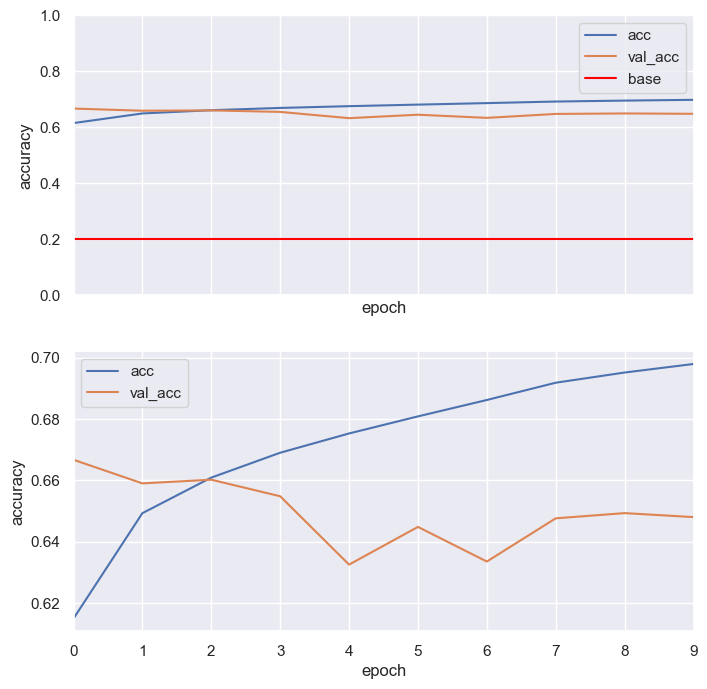

In [388]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8), dpi=100)

for i, ax in enumerate(axes):
    ax.plot(acc, label="acc")
    ax.plot(val_acc, label="val_acc")
    
    ax.set_xlim(0, epochs - 1)
    if i == 0:
        ax.set_ylim(0.0, 1.0)
        ax.axhline(0.2, color="red", label="base")
        
    ax.grid(visible=True, axis="both")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")

plt.show()

##### Test

In [360]:
# Get probabilities per class
y_pred = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [361]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)
y_pred_binary = y_pred_multi >= 3

In [362]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.648
(compare to ~0.2)


In [363]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.8968
(compare to ~0.5)


##### Visualize Attention

In [364]:
# Get attention scores
_, ex_att = model(X_test[0:2], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(ex_att, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(2, 200), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        

In [365]:
X_test_norm[0]

['frightened',
 'life',
 'scream',
 'fall',
 'floor',
 'run',
 'life',
 'literally',
 'cover',
 'sweat',
 'need',
 'inhaler',
 'multiple',
 'time',
 'campus',
 'huge',
 'vip',
 'definitely',
 'pennhurst',
 'amazing',
 'campus',
 'lot',
 'history',
 'actor',
 'fully',
 'commit',
 'make',
 'experience',
 'hair',
 'raise',
 'suggest',
 'place',
 'look',
 'fright',
 'experience']

In [422]:
attns[0][-seq_len + 1:].numpy()

array([0.03946919, 0.03045198, 0.03873347, 0.03242358, 0.0327565 ,
       0.02157219, 0.03087746, 0.03103625, 0.01901345, 0.03340317,
       0.01343764, 0.02466197, 0.02766641, 0.02108599, 0.0270589 ,
       0.03067093, 0.03500921, 0.03098181, 0.0537179 , 0.03029369,
       0.02798569, 0.02586276, 0.04171991, 0.0299181 , 0.04169945,
       0.02045505, 0.02080067, 0.0131506 , 0.0224121 , 0.02372655,
       0.01510942, 0.02786765, 0.06121254, 0.02375784], dtype=float32)

In [415]:
def colors_from_values(values, palette_name="BuGn"):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

<Original Text>
I have never been more frightened in my life.  I screamed, fell on the floor, and ran for my life.  I was literally covered in sweat and needed my inhaler multiple times.  The campus is huge and VIP is definitely the move.  Pennhurst is an amazing campus with lots of history and the actors are fully committed to making the experience hair raising.  I would suggest this place to anyone looking for a frighting experience.

<Preprocessed>
['frightened', 'life', 'scream', 'fall', 'floor', 'run', 'life', 'literally', 'cover', 'sweat', 'need', 'inhaler', 'multiple', 'time', 'campus', 'huge', 'vip', 'definitely', 'pennhurst', 'amazing', 'campus', 'lot', 'history', 'actor', 'fully', 'commit', 'make', 'experience', 'hair', 'raise', 'suggest', 'place', 'look', 'fright', 'experience']


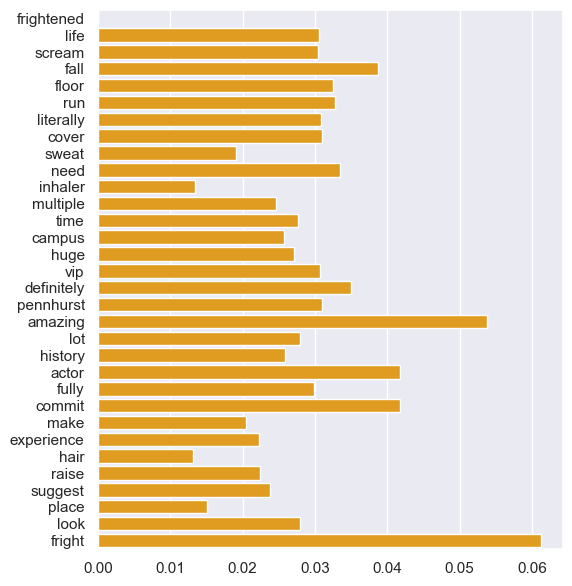

In [425]:
sample_idx = 0

seq_len = len(X_test_norm[sample_idx])
in_seq = X_test_norm[sample_idx]
attn_vals = attns[sample_idx][-seq_len:].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()